In [1]:
import os
import sys
import glob
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("paper")

In [2]:
pd.__version__

'0.24.2'

# Import Simulated Data with MRCC Values

In [3]:
%%bash
mkdir -p ../data
curl -L https://osf.io/e258u/download -o ../data/simreads-compare.dnainput.processed.mrcc.csv.gz
ls ../data

simreads-compare.dnainput.csv.gz
simreads-compare.dnainput.processed.csv.gz
simreads-compare.dnainput.processed.mashD.csv.gz
simreads-compare.dnainput.processed.mrcc.csv.gz


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   459  100   459    0     0   1204      0 --:--:-- --:--:-- --:--:--  1201
100 11.1M  100 11.1M    0     0  2629k      0  0:00:04  0:00:04 --:--:-- 4146k


In [4]:
sDF = pd.read_csv("../data/simreads-compare.dnainput.processed.mrcc.csv.gz")
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh
0,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1,0.192024,0.329152,0.329152,0.315500,4974666,5189923,1637423,dna-21,5082294.5,0.047855,0.051308,0.051773
1,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,100,0.193861,0.332344,0.332344,0.317521,49849,52176,16567,dna-21,5082294.5,0.047855,0.050323,0.051893
2,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1000,0.203267,0.343331,0.343331,0.332559,5001,5163,1717,dna-21,5082294.5,0.047855,0.047708,0.051601
3,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,2000,0.203029,0.344026,0.344026,0.331274,2494,2590,858,dna-21,5082294.5,0.047855,0.046926,0.052235
4,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,31,1,0.108379,0.199794,0.199794,0.191507,4974660,5189923,993907,dna-31,5082291.5,0.047855,0.050369,0.050880


In [5]:
sDF.shape

(273600, 18)

## Assess p-distance estimation

In [6]:
# first, get point estimate from pLow and pHigh
sDF["mc_pdist"] = (sDF["mc_pLow"] + sDF["mc_pHigh"])/2
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist
0,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1,0.192024,0.329152,0.329152,0.315500,4974666,5189923,1637423,dna-21,5082294.5,0.047855,0.051308,0.051773,0.051540
1,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,100,0.193861,0.332344,0.332344,0.317521,49849,52176,16567,dna-21,5082294.5,0.047855,0.050323,0.051893,0.051108
2,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1000,0.203267,0.343331,0.343331,0.332559,5001,5163,1717,dna-21,5082294.5,0.047855,0.047708,0.051601,0.049655
3,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,2000,0.203029,0.344026,0.344026,0.331274,2494,2590,858,dna-21,5082294.5,0.047855,0.046926,0.052235,0.049581
4,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,31,1,0.108379,0.199794,0.199794,0.191507,4974660,5189923,993907,dna-31,5082291.5,0.047855,0.050369,0.050880,0.050624


In [7]:
# let's make a column for the difference between the point estimate and the mc_pdist
sDF["pdist_diff"] = sDF["true p-distance"] - sDF["mc_pdist"]
sDF.head()

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist,pdist_diff
0,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1,0.192024,0.329152,0.329152,0.315500,4974666,5189923,1637423,dna-21,5082294.5,0.047855,0.051308,0.051773,0.051540,-0.003686
1,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,100,0.193861,0.332344,0.332344,0.317521,49849,52176,16567,dna-21,5082294.5,0.047855,0.050323,0.051893,0.051108,-0.003253
2,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,1000,0.203267,0.343331,0.343331,0.332559,5001,5163,1717,dna-21,5082294.5,0.047855,0.047708,0.051601,0.049655,-0.001800
3,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,21,2000,0.203029,0.344026,0.344026,0.331274,2494,2590,858,dna-21,5082294.5,0.047855,0.046926,0.052235,0.049581,-0.001726
4,data-d0.05-f1-nogam-seed11,data-d0.05-f1-nogam-seed11-seq1,data-d0.05-f1-nogam-seed11-seq2,dna,31,1,0.108379,0.199794,0.199794,0.191507,4974660,5189923,993907,dna-31,5082291.5,0.047855,0.050369,0.050880,0.050624,-0.002770


In [8]:
# this Dataframe includes 4 scaled values, 3 ksize values == 12 combinations per simulated read pair comparison
sDF[sDF["comparison_name"] == "data-d0.05-f1-nogam-seed36"] #example

,comparison_name,sig1_name,sig2_name,alphabet,ksize,scaled,jaccard,max_containment,sig1_containment,sig2_containment,sig1_hashes,sig2_hashes,num_common,alpha-ksize,num_unique_kmers,true p-distance,mc_pLow,mc_pHigh,mc_pdist,pdist_diff
660,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1,0.190577,0.320984,0.319303,0.320984,4993153,4967010,1594331,dna-21,4980081.5,0.047995,0.052436,0.052913,0.052675,-0.004679
661,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,100,0.192184,0.322739,0.322739,0.322077,49616,49718,16013,dna-21,4980081.5,0.047995,0.051623,0.053241,0.052432,-0.004437
662,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,1000,0.197087,0.332343,0.326269,0.332343,5143,5049,1678,dna-21,4980081.5,0.047995,0.049115,0.053137,0.051126,-0.003131
663,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,21,2000,0.201250,0.338455,0.331748,0.338455,2523,2473,837,dna-21,4980081.5,0.047995,0.047607,0.053033,0.050320,-0.002325
664,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1,0.107025,0.193865,0.192850,0.193865,4993150,4967004,962929,dna-31,4980077.0,0.047995,0.051284,0.051808,0.051546,-0.003551
665,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,100,0.106976,0.193632,0.192922,0.193632,49932,49749,9633,dna-31,4980077.0,0.047995,0.050779,0.052394,0.051586,-0.003591
666,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,1000,0.104772,0.192540,0.186888,0.192540,5110,4960,955,dna-31,4980077.0,0.047995,0.049772,0.053775,0.051774,-0.003778
667,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,31,2000,0.105969,0.193944,0.189373,0.193944,2503,2444,474,dna-31,4980077.0,0.047995,0.048855,0.054275,0.051565,-0.003569
668,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,51,1,0.036558,0.070724,0.070353,0.070724,4993130,4966984,351283,dna-51,4980057.0,0.047995,0.050286,0.050943,0.050614,-0.002619
669,data-d0.05-f1-nogam-seed36,data-d0.05-f1-nogam-seed36-seq1,data-d0.05-f1-nogam-seed36-seq2,dna,51,100,0.036894,0.071625,0.070704,0.071625,49997,49354,3535,dna-51,4980057.0,0.047995,0.049471,0.051296,0.050383,-0.002388


# Point estimate comparisons

In [9]:
# there are some comparisons with no k-mers/hashes in common -- let's eliminate these
sDF = sDF[sDF["num_common"] != 0]
sDF.shape

(155143, 20)

In [10]:
# let's just work with scaled=1 to start:
s1DF = sDF[sDF["scaled"] == 1]

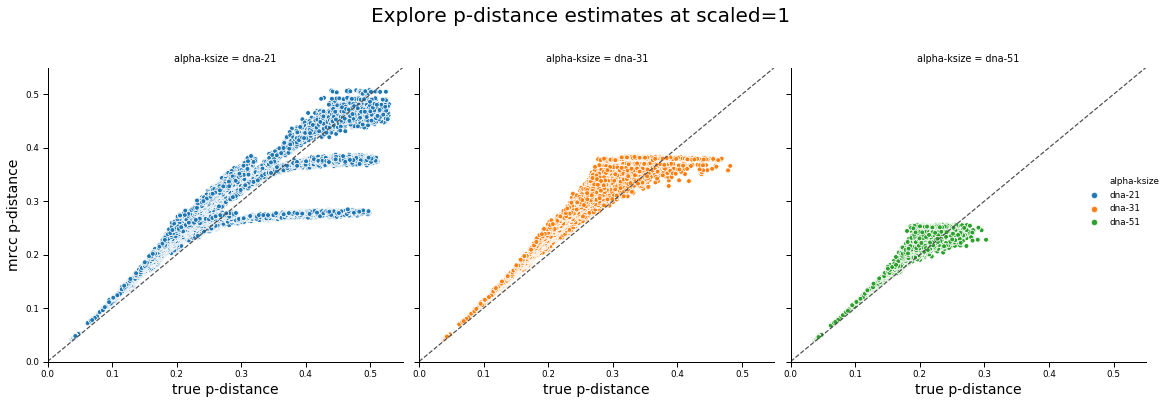

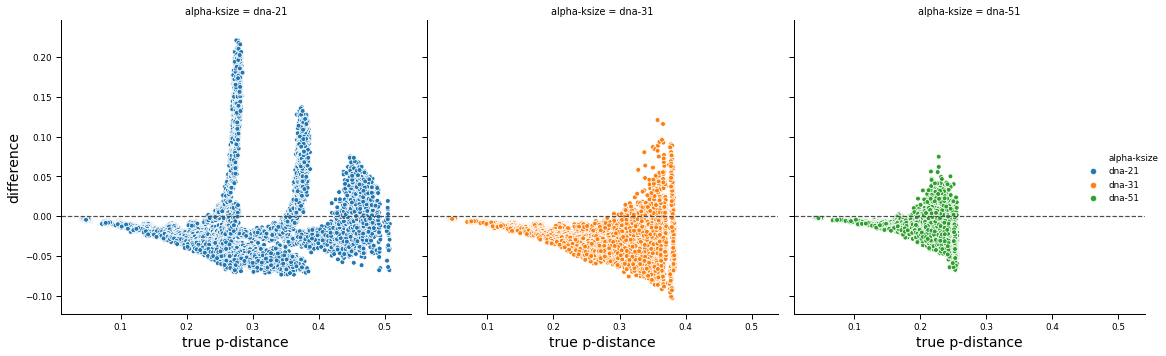

In [11]:
data_to_plot = s1DF # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()


In [12]:
sDF_3 = s1DF[s1DF["num_common"] >= 3]

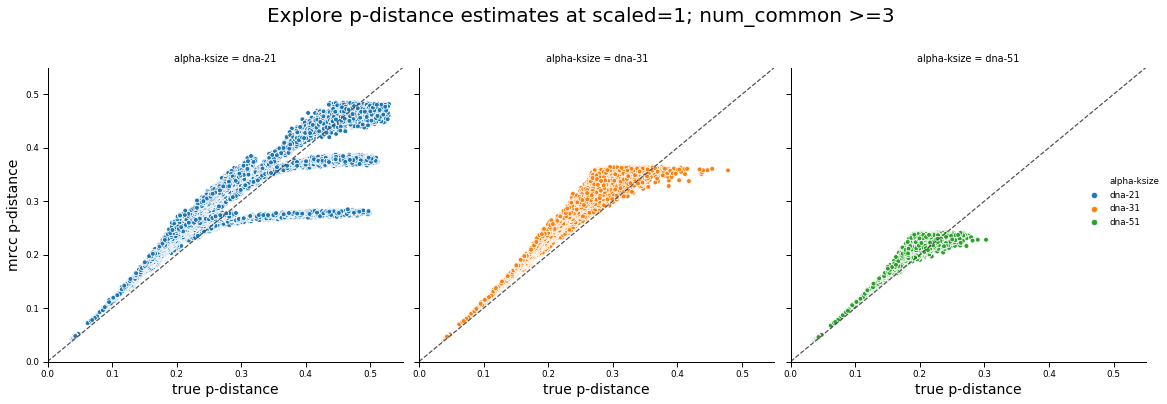

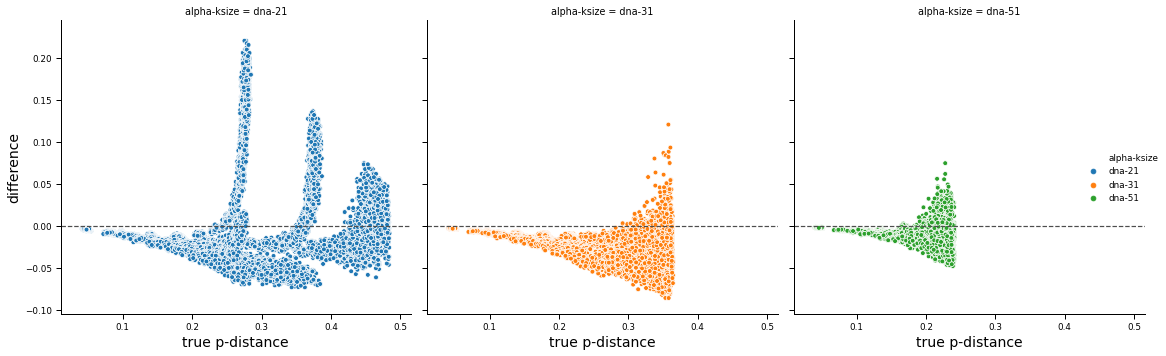

In [13]:
data_to_plot = sDF_3 # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; num_common >=3", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

In [14]:
sDF_minC = s1DF[s1DF["max_containment"] >= 0.0001]

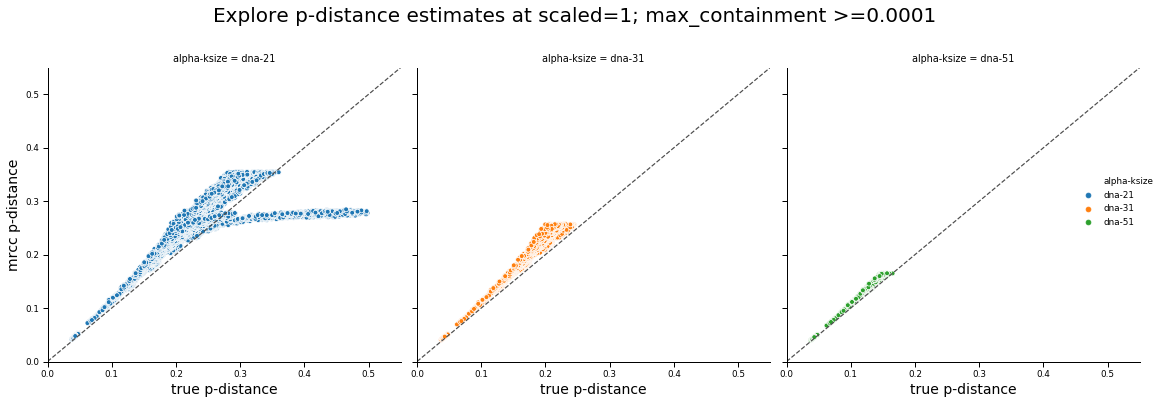

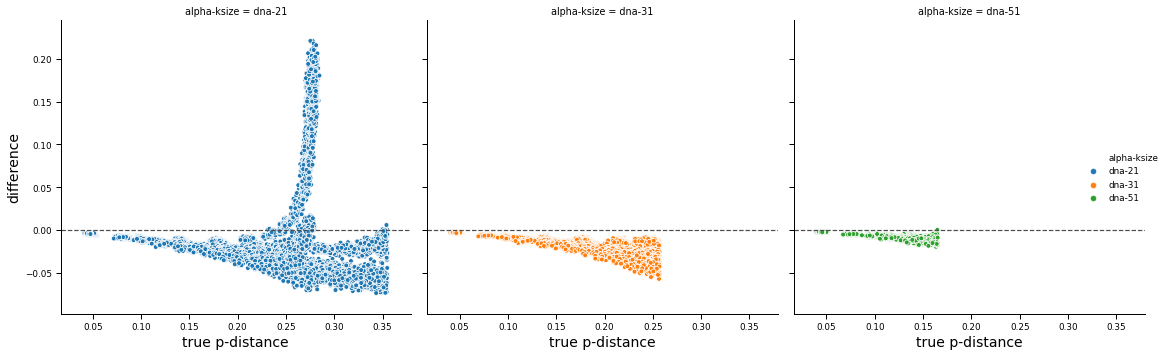

In [15]:
data_to_plot = sDF_minC # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; max_containment >=0.0001", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

In [16]:
sDF_minC2 = s1DF[s1DF["max_containment"] >= 0.0002]

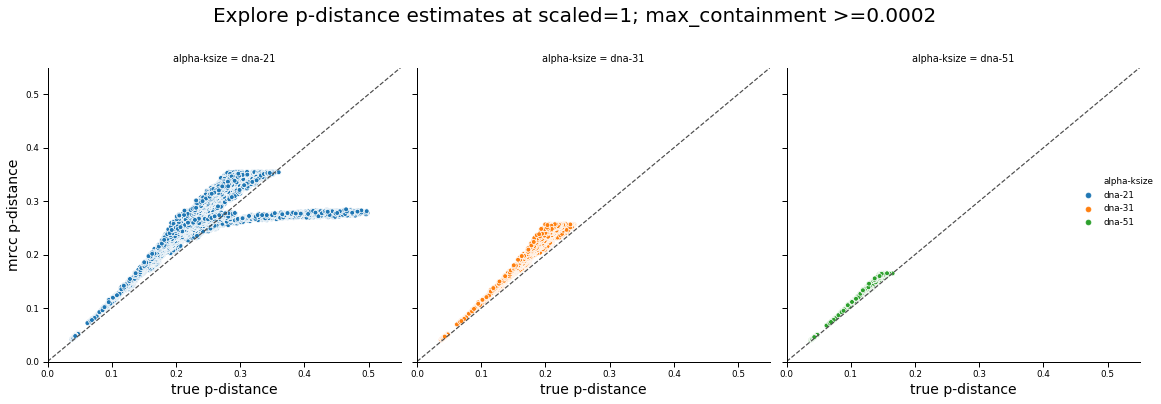

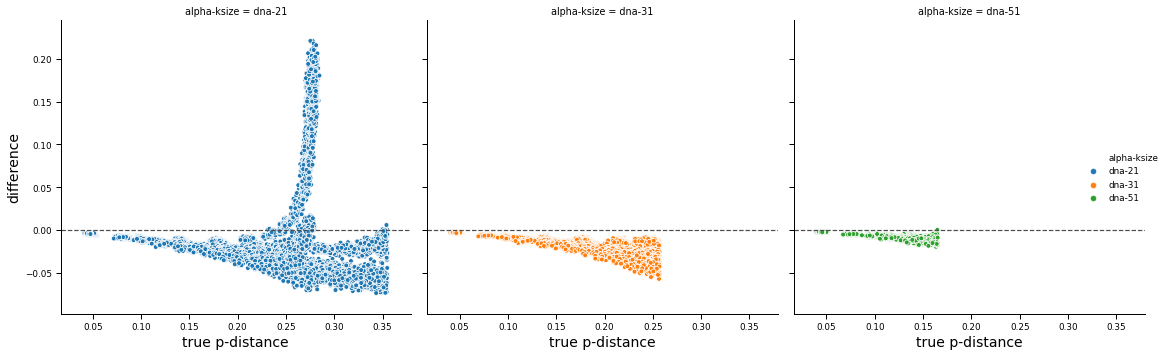

In [17]:
data_to_plot = sDF_minC # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1; max_containment >=0.0002", x=0.5, y=1.10, size=20)


d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()

# CI Plotting

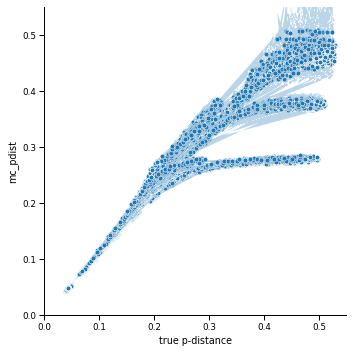

In [18]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

#xlim =g.get_xlim()
#ylim = g.get_ylim()
#g.plot(xlim, ylim, ls="--", c=".3")
#g.set_xlabel("true p-distance", size=14)
#g.set_ylabel("mrcc p-distance", size=14)
#g.add_legend()
#g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)


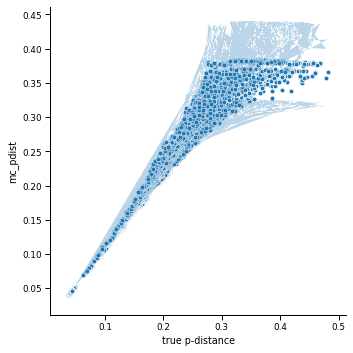

In [19]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-31"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
#g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

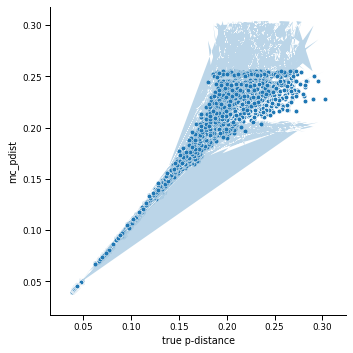

In [20]:

data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-51"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
#g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"

## Attempt to plot all confidence values at once

Note -- inprogress. The plot below plots all confidence values on all plots, does not split them out by alpha/ksize, as should be done

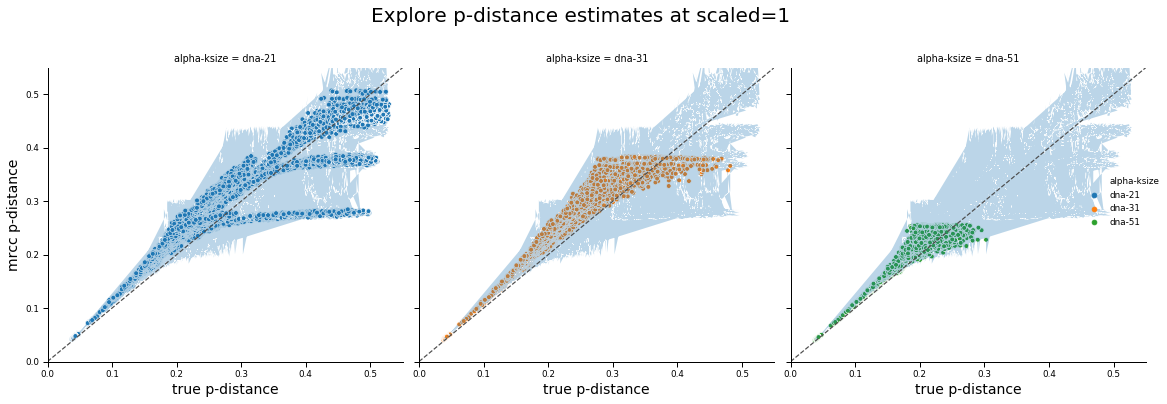

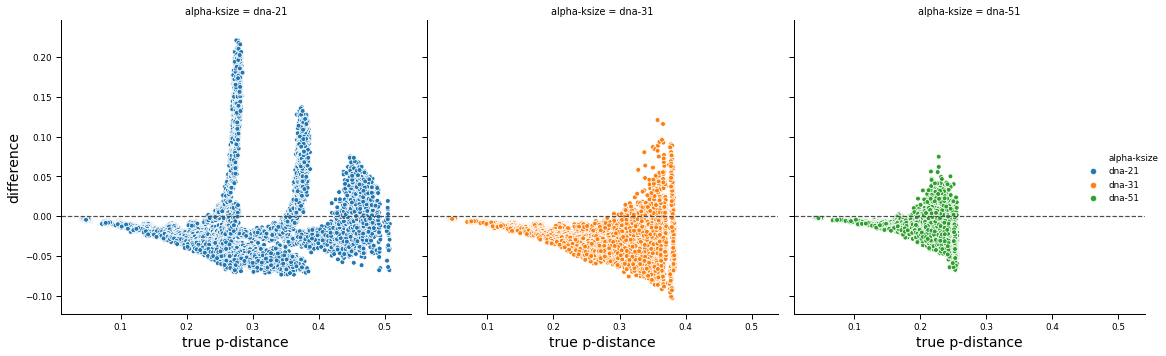

In [21]:
data_to_plot = s1DF # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist", col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ## this is ALL confidence values, not done by alpha-ksize :(())
    ax.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
g.add_legend()
g.fig.suptitle("Explore p-distance estimates at scaled=1", x=0.5, y=1.10, size=20)

d = sns.relplot(data=data_to_plot, x="mc_pdist", y="pdist_diff", col="alpha-ksize", hue="alpha-ksize")
for ax in d.fig.axes:
    ax.axhline(0, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("difference", size=14)
d.add_legend()


# Explore Scaled = 1 vs Scaled=100, 1000, 2000 (k=21)

In [22]:
# scaled=100
s100DF = sDF[sDF["scaled"] == 100]
# scaled=1000
s1000DF = sDF[sDF["scaled"] == 1000]
# scaled=2000
s2000DF = sDF[sDF["scaled"] == 2000]

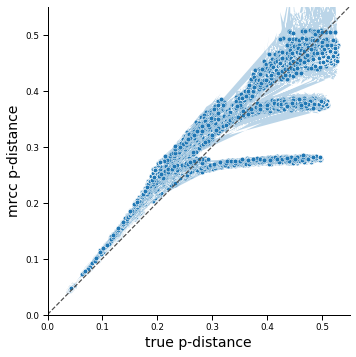

In [23]:
data_to_plot = s1DF[s1DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
    

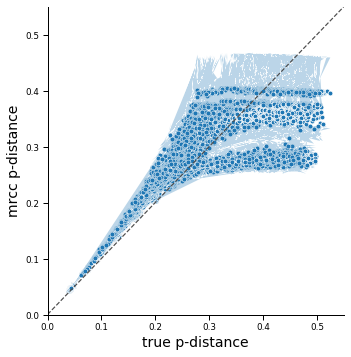

In [24]:
data_to_plot = s100DF[s100DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)

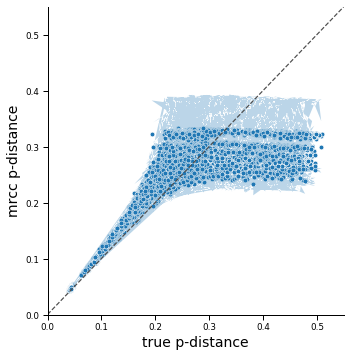

In [25]:
data_to_plot = s1000DF[s1000DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
    

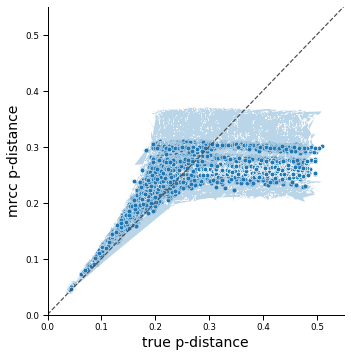

In [26]:
data_to_plot = s2000DF[s2000DF["alpha-ksize"] == "dna-21"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
    

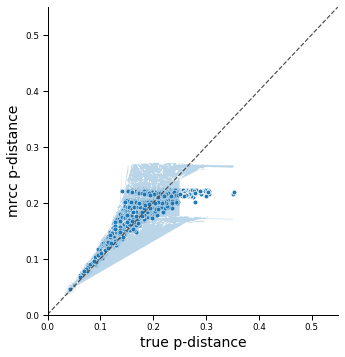

In [27]:
data_to_plot = s2000DF[s2000DF["alpha-ksize"] == "dna-31"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)
    

# explore scaled, k=31

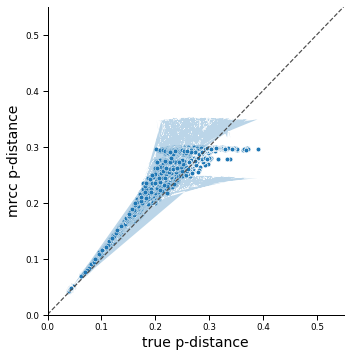

In [28]:
data_to_plot = s100DF[s100DF["alpha-ksize"] == "dna-31"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)

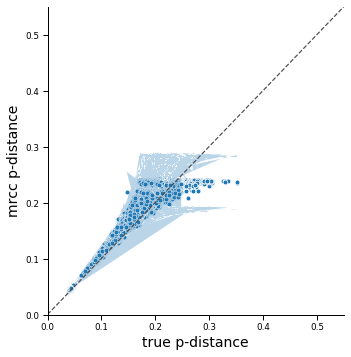

In [29]:
data_to_plot = s1000DF[s1000DF["alpha-ksize"] == "dna-31"] # select dataframe to plot with

g = sns.relplot(data=data_to_plot, x="true p-distance", y="mc_pdist")#, col="alpha-ksize", hue="alpha-ksize")#, palette="GnBu_d")
g.set(xlim=(0, 0.55), ylim=(0, 0.55), xticks=np.arange(0, 0.60, 0.1), yticks=np.arange(0, 0.60, 0.1))
plt.fill_between(data_to_plot["true p-distance"], data_to_plot["mc_pLow"], data_to_plot["mc_pHigh"], alpha=0.3, edgecolor="")#color="#b9cfe7"
xlim=None
for ax in g.fig.axes:
    if not xlim:
        xlim =ax.get_xlim()
        ylim = ax.get_ylim()
    ax.plot(xlim, ylim, ls="--", c=".3")
    ax.set_xlabel("true p-distance", size=14)
    ax.set_ylabel("mrcc p-distance", size=14)